<a href="https://colab.research.google.com/github/ParthikB/F.R.I.E.N.D.S/blob/master/fastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.vision import *
import os
import numpy as np

# Mount the drive
ROOT = '/content/drive/My Drive/Colab Notebooks/friends'
path = Path('./data_fastai')

os.chdir(ROOT)

# Scraping the Images

In [0]:
# Search for the Image in google Images and then execute this JS Command
# urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
# window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

In [0]:

folder = ['joey', 'ross', 'chandler', 'rachel', 'phoebe', 'monica']
file   = ['joey_urls.csv', 'ross_urls.csv', 'chandler_urls.csv', 'rachel_urls.csv', 'phoebe_urls.csv', 'monica_urls.csv']

for f, fname in zip(folder, file):
  path = Path('./data_fastai')
  dest = path/f
  dest.mkdir(parents=True, exist_ok=True)
  # print(path/fname, dest)
  download_images(path/fname, dest, max_pics=200)

In [4]:
path.ls()

[PosixPath('data_fastai/joey_urls.csv'),
 PosixPath('data_fastai/chandler_urls.csv'),
 PosixPath('data_fastai/phoebe_urls.csv'),
 PosixPath('data_fastai/ross_urls.csv'),
 PosixPath('data_fastai/rachel_urls.csv'),
 PosixPath('data_fastai/chandler'),
 PosixPath('data_fastai/monica_urls.csv'),
 PosixPath('data_fastai/joey'),
 PosixPath('data_fastai/ross'),
 PosixPath('data_fastai/monica'),
 PosixPath('data_fastai/phoebe'),
 PosixPath('data_fastai/rachel'),
 PosixPath('data_fastai/models'),
 PosixPath('data_fastai/cleaned.csv')]

In [0]:
# Now, we remove any image that cannot be opened..
for c in folder:
  print('Verifying',c)
  verify_images(path/c, delete=True, max_size=500)

Verifying joey


Verifying ross


Verifying chandler


Verifying rachel


Verifying phoebe


Verifying monica


In [0]:
# Seeing the Balance
for f in folder:
  temp_path = path/f
  print(f'Total Images in {f} Class :', len(temp_path.ls()))

Total Images in joey Class : 99
Total Images in ross Class : 69
Total Images in chandler Class : 95
Total Images in rachel Class : 100
Total Images in phoebe Class : 101
Total Images in monica Class : 87


## Creating a ImageDataBunch Object

In [0]:
np.random.seed(10)
data = ImageDataBunch.from_folder(path,
                                  train='.',
                                  valid_pct=0.2,
                                  # valid='valid',
                                  ds_tfms=get_transforms(),
                                  size=224,
                                  num_workers=4).normalize(imagenet_stats)

In [6]:
data

ImageDataBunch;

Train: LabelList (441 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
chandler,chandler,chandler,chandler,chandler
Path: data_fastai;

Valid: LabelList (110 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
phoebe,ross,ross,monica,ross
Path: data_fastai;

Test: None

### Visualizing the Dataset

Total Classes : 6
Classes       : ['chandler', 'joey', 'monica', 'phoebe', 'rachel', 'ross']


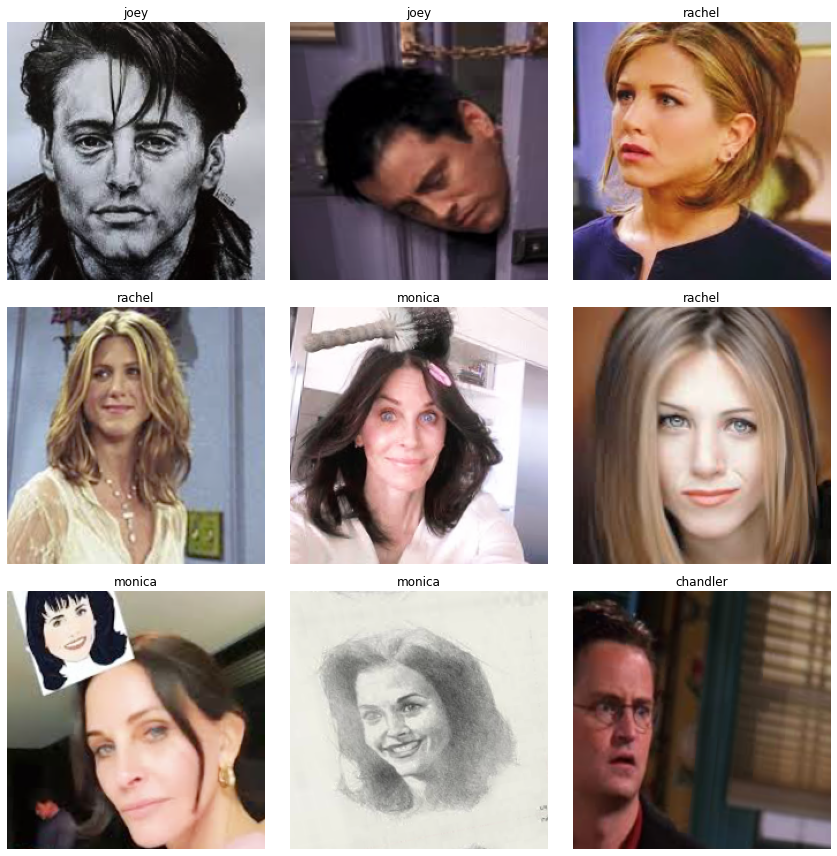

In [0]:
print('Total Classes :', data.c)
print('Classes       :', data.classes)
data.show_batch(rows=3)

# TRAINING

* Download the pretrained model
* Find the Learning_rate range
* Run few epochs
* (Optional) Save the model before tampering with it
* Unfreeze the network
* Run Few more epochs

In [7]:
# Downloading the pretrained weights
learner = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
# Loading any previously saved model
# learner.load('stage-1_0.26');
learner.load('stage-2_0.17');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


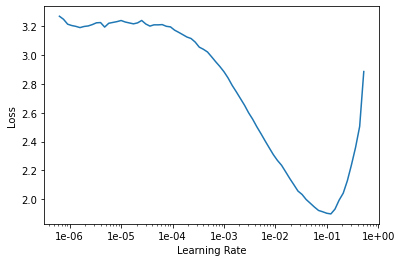

In [0]:
learner.lr_find()

learner.recorder.plot()

In [0]:
EPOCHS = 5
learner.fit_one_cycle(cyc_len=EPOCHS, 
                      max_lr=slice(1e-04, 1e-01))

epoch,train_loss,valid_loss,error_rate,time
0,1.611410,3.821767,0.336364,00:05
1,1.488980,2.049313,0.263636,00:05
2,1.471297,2.609923,0.281818,00:05
3,1.356967,2.065379,0.309091,00:05
4,1.267334,1.790367,0.263636,00:05



### Saving the Model

In [0]:
os.chdir(ROOT)

learner.save('stage-1_0.26')

In [0]:
learner.load('stage-1_0.26');

## Unfreezing the Model

In [0]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


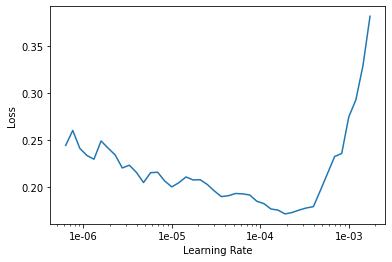

In [0]:
learner.lr_find()

learner.recorder.plot()

In [0]:
# NOTE: I used many different combinations of learning rates with many epochs. So...keep trying.

learner.fit_one_cycle(3, max_lr=slice(2e-06, 6e-06))

epoch,train_loss,valid_loss,error_rate,time
0,0.207782,0.893311,0.172727,00:05
1,0.232489,0.903274,0.163636,00:05
2,0.217371,0.909600,0.163636,00:06


In [0]:
learner.save('stage-2_0.17')

# Interpretation

In [10]:
interp = ClassificationInterpretation.from_learner(learner)

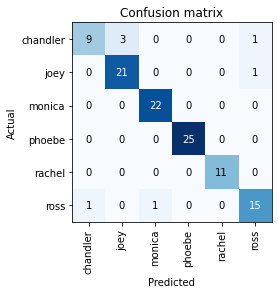

In [11]:
# Confusion Matrix
interp.plot_confusion_matrix()

# Cleaning up the DATA to elevate performance

In [0]:
from fastai.widgets import *

In [0]:
# Created a databunch object without any validation/test set.

db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [0]:
# Creating a new model object
learner_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

# Loading the previously trained weights onto this new model object
learner_cln.load('stage-2_0.17');

In [0]:
ds, idx = DatasetFormatter().from_toplosses(learner_cln)

In [0]:
ds

LabelList (551 items)
x: ImageList
Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300)
y: CategoryList
chandler,chandler,chandler,chandler,chandler
Path: data_fastai

In [0]:
# Run the following code in Jupyter NOTEBOOK only, else the runtime will break.

# ImageCleaner(ds, idx, path)

# Putting Model in Produciton

In [0]:

# First thing first, let's export the content of our Learner object for production:
learner.export()

# This will create a file named 'export.pkl' in the directory where we were working 
# that contains everything we need to deploy our model (the model, the weights but 
# also some metadata like the classes or the transforms/normalization used).

In [0]:
# We'll be using CPU INFERENCE in production becaue:
# > Mainly, GPU is used for training purpose, which will not be done in production
# > Also, CPU are way cheaper
# > Until we don't have a big website with lots of traffic, we won't get a lot of calls to our model and 
#   we won't need to create a batch to send to GPU. CPU can take that load easily.
# > CPUs are more scalable

defaults.device = torch.device('cpu')

### Downloading a test image

In [0]:
os.chdir(ROOT)
import requests

def download_image(url, fname, path=None):
  if path:
    os.chdir(ROOT+path)

  f = open(f'{fname}.jpg','wb')
  f.write(requests.get(url).content)
  f.close()
  print(f'{fname}.jpg downloaded.')

rach_test.jpg downloaded.


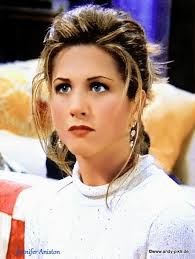

In [54]:
RACH2_URL = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRYqU-ZdbYG3kqvo-6HUqOFEYuZHuG4pg4qjo6Bi_Zcvq7TGNaE&usqp=CAU'
RACH2_FNAME = 'rach_test'

download_image(RACH2_URL, RACH2_FNAME, '/data_fastai')

os.chdir(ROOT)
rach1 = open_image(path/f'{RACH2_FNAME}.jpg')
rach1

rach2_test.jpg downloaded.


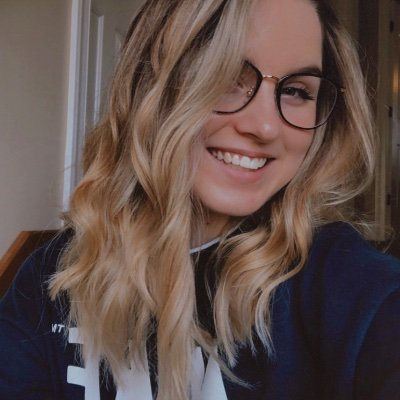

In [55]:
RACH2_URL = 'https://pbs.twimg.com/profile_images/1194061052591378432/vap2TfkO_400x400.jpg'
RACH2_FNAME = 'rach2_test'

download_image(RACH2_URL, RACH2_FNAME, '/data_fastai')

os.chdir(ROOT)
rach2 = open_image(path/f'{RACH2_FNAME}.jpg')
rach2

## Loading the production model

In [0]:
model = load_learner(path)

In [58]:
pred_class,pred_idx,outputs = model.predict(rach2)
pred_class

Category rachel